<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

**1.1 Загрузка библиотек и глобальных переменных.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

**1.2 Пользовательские функции.**

In [2]:
# Напишем функцию для первичной проверки данных

def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
     
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

**1.3 Загрузим данные.**

In [3]:
# Обучающая выборка

df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')    

In [4]:
df_train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [5]:
# Тестовая выборка

df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [6]:
df_test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [7]:
# Исходные данные

df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [8]:
df_full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


**1.4 Первичный осмотр данных.**

In [9]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ 
# Обучающая выборка

check_data(df_train)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               1

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.000000,4.211620,4.994652,5.859540,16.001945
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.000000,9.297355,10.297144,11.170603,17.031899
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.000000,7.484645,8.845462,10.487508,18.124851
final.output.concentrate_au,14149.0,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final.output.recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,14148.0,-483.956022,37.892788,-797.142475,-500.363177,-499.702452,-487.712108,-275.073125
secondary_cleaner.state.floatbank5_b_air,14148.0,13.064590,5.765617,0.646208,8.994405,11.997547,17.982903,27.926001
secondary_cleaner.state.floatbank5_b_level,14148.0,-483.966564,39.207913,-800.006180,-500.105994,-499.914556,-453.186936,-157.396071
secondary_cleaner.state.floatbank6_a_air,14147.0,19.577539,5.764417,0.195324,14.989304,19.984175,24.991623,32.188906



Описание категориальных данных:


,count,unique,top,freq
date,14149,14149,2017-05-10 19:59:59,1



Вывод уникальных значений по каждому категориаьному признаку:
_date


2017-05-10 19:59:59    1
2016-02-12 05:00:00    1
2018-02-22 00:59:59    1
2018-04-22 00:59:59    1
2016-05-19 20:59:59    1
                      ..
2016-02-09 04:00:00    1
2017-04-10 01:59:59    1
2017-07-28 19:59:59    1
2018-06-01 09:59:59    1
2017-07-13 19:59:59    1
Name: date, Length: 14149, dtype: int64

In [10]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ 
# Тестовая выборка

check_data(df_test)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   fl

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035



Описание категориальных данных:


,count,unique,top,freq
date,5290,5290,2017-09-19 01:59:59,1



Вывод уникальных значений по каждому категориаьному признаку:
_date


2017-09-19 01:59:59    1
2016-12-03 02:59:59    1
2017-12-24 06:59:59    1
2016-12-03 03:59:59    1
2016-10-15 10:59:59    1
                      ..
2017-10-24 06:59:59    1
2016-12-25 04:59:59    1
2017-11-08 17:59:59    1
2016-12-24 03:59:59    1
2017-10-09 22:59:59    1
Name: date, Length: 5290, dtype: int64

In [11]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ 
# Исходные данные

check_data(df_full)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               1

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final.output.concentrate_sol,19228.0,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final.output.recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,19438.0,-488.684065,34.533396,-797.323986,-500.458467,-499.802605,-498.384187,-244.483566
secondary_cleaner.state.floatbank5_b_air,19438.0,12.198224,5.333024,0.528083,8.971105,11.019433,14.019088,27.926001
secondary_cleaner.state.floatbank5_b_level,19438.0,-487.149827,38.347312,-800.220337,-500.129462,-499.935317,-499.436708,-137.740004
secondary_cleaner.state.floatbank6_a_air,19437.0,18.959024,5.550498,-0.079426,14.983037,19.960541,24.003170,32.188906



Описание категориальных данных:


,count,unique,top,freq
date,19439,19439,2017-05-10 19:59:59,1



Вывод уникальных значений по каждому категориаьному признаку:
_date


2017-05-10 19:59:59    1
2017-06-05 00:59:59    1
2016-08-18 00:59:59    1
2016-10-28 07:59:59    1
2018-03-16 18:59:59    1
                      ..
2018-04-27 12:59:59    1
2016-06-24 23:59:59    1
2017-09-01 03:59:59    1
2017-07-16 04:59:59    1
2018-08-12 07:59:59    1
Name: date, Length: 19439, dtype: int64

**Вывод:**
- мы имеем три таблицы: обучающая выборка, тестовая выборка и исходные данные;
- во всех таблицах есть пропуски;
- некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже;


**1.5 Проверим, что эффективность обогащения рассчитана правильно.**

recovery = (C*(F-T)) / (F*(C-T)) * 100, где:

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [12]:
# создадим функцию для расчета эффективности обогащения

def calc_recovery(C, F, T):
    recovery = (C*(F-T)) / (F*(C-T)) * 100
    return recovery
                

In [13]:
# Вычислим эффективность на обучающей выборке для признака rougher.output.recovery

recovery = calc_recovery(df_train['rougher.output.concentrate_au'],
                         df_train['rougher.input.feed_au'],
                         df_train['rougher.output.tail_au'])


In [14]:
recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [15]:
# Найдем MAE между вашими расчётами и значением признака

mae = mean_absolute_error(recovery, df_train['rougher.output.recovery'])

In [16]:
print('Абсолютная средняя ошибка между расчётами и значением признака =', mae)

Абсолютная средняя ошибка между расчётами и значением признака = 9.73512347450521e-15


**Вывод:** \
Абсолютная средняя ошибка между расчётами и значением признака = 9.73512347450521e-15 и очень мала, из чего следует, что наши расчёты верны.


**1.6 Проанализируем признаки, недоступные в тестовой выборке.**

In [17]:
# Посмотрим каких признаков нет в тестовой выборке

signs_missed = set(df_train.columns) - set(df_test.columns)

In [18]:
# Определим тип данных

df_train[signs_missed].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   secondary_cleaner.output.tail_sol                   12544 non-null  float64
 1   primary_cleaner.output.tail_ag                      14148 non-null  float64
 2   final.output.tail_pb                                14049 non-null  float64
 3   rougher.output.tail_ag                              14148 non-null  float64
 4   rougher.output.recovery                             14149 non-null  float64
 5   secondary_cleaner.output.tail_ag                    14147 non-null  float64
 6   final.output.tail_au                                14149 non-null  float64
 7   final.output.concentrate_au                         14149 non-null  float64
 8   final.output.concentrate_sol                        13938 non-null  float64


**Вывод:**
- все столбцы имеют тип - float64;
- в тестовой выборке недоступны 34 признака;
- 30 признаков имеют тип - _параметры продукта_;
- 4 признака имеют тип - _расчётные характеристики_.


**Отсутствуют 12 признаков на стадии _флотации_:**
- 'rougher.output.concentrate_ag',
- 'rougher.output.concentrate_au',
- 'rougher.output.concentrate_pb',
- 'rougher.output.concentrate_sol',
- 'rougher.output.tail_ag',
- 'rougher.output.tail_au',
- 'rougher.output.tail_pb',
- 'rougher.output.tail_sol',
- 'rougher.calculation.au_pb_ratio',
- 'rougher.calculation.floatbank10_sulfate_to_au_feed',
- 'rougher.calculation.floatbank11_sulfate_to_au_feed',
- 'rougher.calculation.sulfate_to_au_concentrate',


**Отсутствуют 8 признаков на стадии _первичной_очистки_:**
- 'primary_cleaner.output.concentrate_ag',
- 'primary_cleaner.output.concentrate_au',
- 'primary_cleaner.output.concentrate_pb',
- 'primary_cleaner.output.concentrate_sol',
- 'primary_cleaner.output.tail_ag',
- 'primary_cleaner.output.tail_au',
- 'primary_cleaner.output.tail_pb',
- 'primary_cleaner.output.tail_sol',

**Отсутствуют 4 признака на стадии _вторичной_очистки_:**
- 'secondary_cleaner.output.tail_ag',
- 'secondary_cleaner.output.tail_au',
- 'secondary_cleaner.output.tail_pb',
- 'secondary_cleaner.output.tail_sol'}

**Отсутствуют 8 признаков на стадии _финальные характеристики_:**
- 'final.output.concentrate_ag',
- 'final.output.concentrate_au',
- 'final.output.concentrate_pb',
- 'final.output.concentrate_sol',
- 'final.output.tail_ag',
- 'final.output.tail_au',
- 'final.output.tail_pb',
- 'final.output.tail_sol',

**Отсутствуют 2 целевых признака:**
- 'rougher.output.recovery',
- 'final.output.recovery'.



**1.7 Проведём предобработку данных.**

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Поэтому заполним пропущенные значения функцией ffill() и заменим нулевые значения последним значением признака:

In [19]:
# Обучающая выборка
# Количество пропусков: 4100

df_train = df_train.ffill(axis=0)

print('Количество пропусков в обучающей выборке:', df_train.isna().sum().sum())

Количество пропусков в обучающей выборке: 0


In [20]:
# Тестовая выборка
# Количество пропусков: 90

df_test = df_test.ffill(axis=0)

print('Количество пропусков в тестовой выборке:', df_test.isna().sum().sum())

Количество пропусков в тестовой выборке: 0


In [21]:
# Исходные данные
# Количество пропусков: 4481

df_full = df_full.ffill(axis=0)

print('Количество пропусков в исходных данных:', df_full.isna().sum().sum())

Количество пропусков в исходных данных: 0


В тестовом наборе нет целевых признаков, добавим с помощью метода merge():

In [22]:
df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']],
                        on='date')


In [23]:
df_test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

**Вывод:**
- произведена предобработка данных;
- заполнены пропущенные значения;
- в тестовый набор добавлены целевые признаки.

## Анализ данных

**2.1 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.**

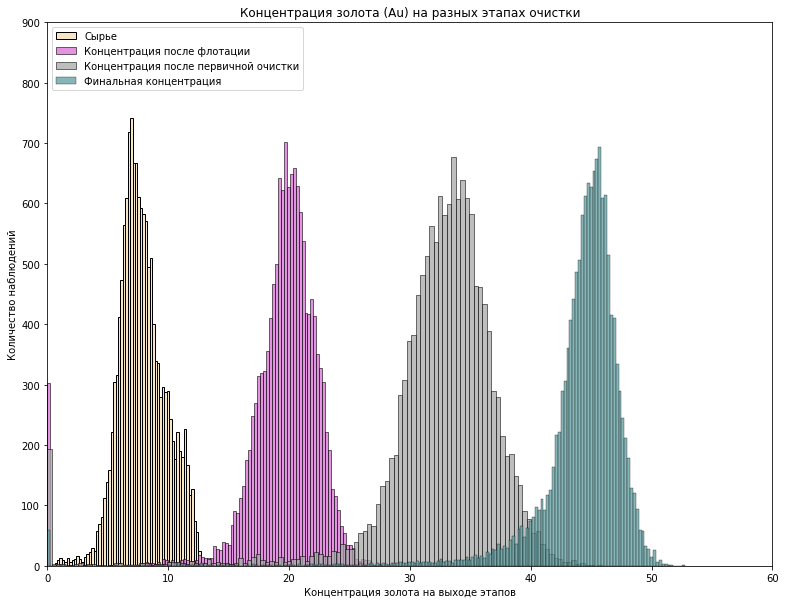

In [24]:
# концентрация золота

plt.figure(figsize=[13, 10])

sns.histplot(df_train['rougher.input.feed_au'], label='Сырье', color='wheat')

sns.histplot(df_train['rougher.output.concentrate_au'], label='Концентрация после флотации',
             color='orchid')

sns.histplot(df_train['primary_cleaner.output.concentrate_au'], 
             label='Концентрация после первичной очистки', color='darkgrey')

sns.histplot(df_train['final.output.concentrate_au'], 
             label='Финальная концентрация', color='cadetblue')

plt.xlim([0, 60])
plt.ylim([0, 900])

plt.xlabel('Концентрация золота на выходе этапов')
plt.ylabel('Количество наблюдений')

plt.legend(loc='upper left')
plt.title('Концентрация золота (Au) на разных этапах очистки')
plt.show()

In [25]:
print('Средняя концентрация золота на этапе сырья:', 
      df_train['rougher.input.feed_au'].mean().round(2))

print('Средняя концентрация золота после флотации:', 
      df_train['rougher.output.concentrate_au'].mean().round(2))

print('Средняя концентрация золота после первичной очистки:', 
      df_train['primary_cleaner.output.concentrate_au']
      .mean().round(2))

print('Средняя концентрация золота на финальном этапе:', 
      df_train['final.output.concentrate_au'].mean().round(2))

Средняя концентрация золота на этапе сырья: 7.87
Средняя концентрация золота после флотации: 19.44
Средняя концентрация золота после первичной очистки: 32.39
Средняя концентрация золота на финальном этапе: 44.0


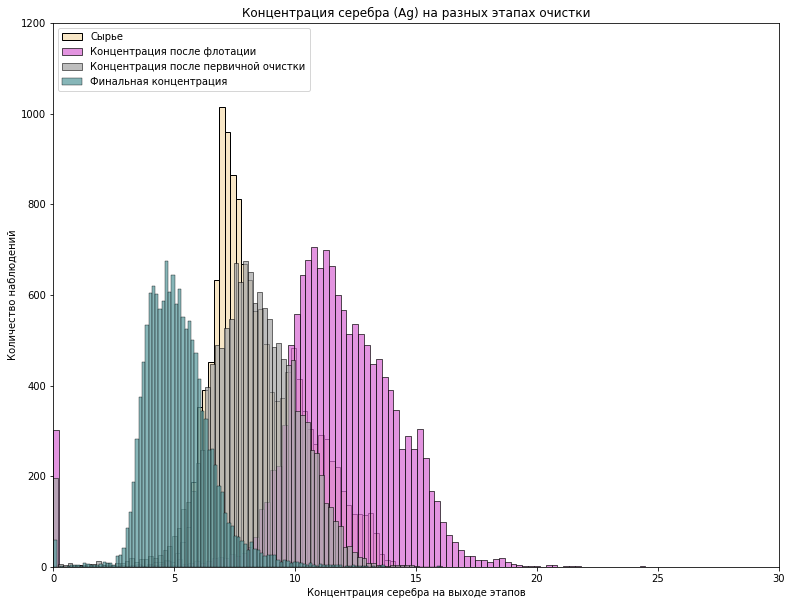

In [26]:
# концентрация серебра

plt.figure(figsize=[13, 10])

sns.histplot(df_train['rougher.input.feed_ag'], label='Сырье', color='wheat')

sns.histplot(df_train['rougher.output.concentrate_ag'], label='Концентрация после флотации', 
             color='orchid')

sns.histplot(df_train['primary_cleaner.output.concentrate_ag'], 
             label='Концентрация после первичной очистки',
             color='darkgrey')

sns.histplot(df_train['final.output.concentrate_ag'], label='Финальная концентрация', 
             color='cadetblue')

plt.xlim([0, 30])
plt.ylim([0, 1200])

plt.xlabel('Концентрация серебра на выходе этапов')
plt.ylabel('Количество наблюдений')

plt.legend(loc='upper left')
plt.title('Концентрация серебра (Ag) на разных этапах очистки')
plt.show()

In [27]:
print('Средняя концентрация серебра на этапе сырья:', 
      df_train['rougher.input.feed_ag'].mean().round(2))

print('Средняя концентрация серебра после флотации:', 
      df_train['rougher.output.concentrate_ag'].mean().round(2))

print('Средняя концентрация серебра после первичной очистки:', 
      df_train['primary_cleaner.output.concentrate_ag']
      .mean().round(2))

print('Средняя концентрация серебра на финальном этапе:', 
      df_train['final.output.concentrate_ag'].mean().round(2))

Средняя концентрация серебра на этапе сырья: 8.58
Средняя концентрация серебра после флотации: 11.78
Средняя концентрация серебра после первичной очистки: 8.2
Средняя концентрация серебра на финальном этапе: 5.14


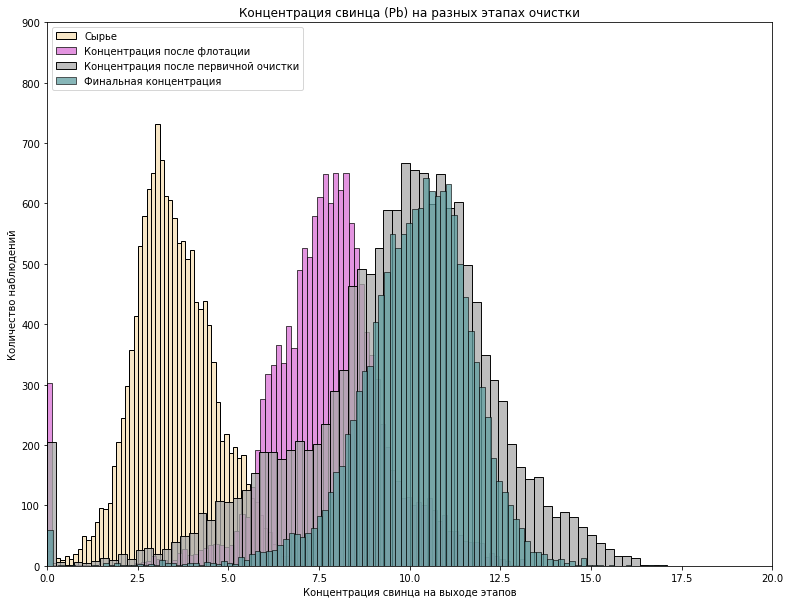

In [28]:
# концентрация свинца

plt.figure(figsize=[13, 10])

sns.histplot(df_train['rougher.input.feed_pb'], label='Сырье', color='wheat')

sns.histplot(df_train['rougher.output.concentrate_pb'], label='Концентрация после флотации', 
             color='orchid')

sns.histplot(df_train['primary_cleaner.output.concentrate_pb'], 
             label='Концентрация после первичной очистки',
             color='darkgrey')

sns.histplot(df_train['final.output.concentrate_pb'], label='Финальная концентрация', 
             color='cadetblue')

plt.xlim([0, 20])
plt.ylim([0, 900])

plt.xlabel('Концентрация свинца на выходе этапов')
plt.ylabel('Количество наблюдений')

plt.legend(loc='upper left')
plt.title('Концентрация свинца (Pb) на разных этапах очистки')
plt.show()

In [29]:
print('Средняя концентрация свинца на этапе сырья:', 
      df_train['rougher.input.feed_pb'].mean().round(2))

print('Средняя концентрация свинца после флотации:', 
      df_train['rougher.output.concentrate_pb'].mean().round(2))

print('Средняя концентрация свинца после первичной очистки:', 
      df_train['primary_cleaner.output.concentrate_pb']
      .mean().round(2))

print('Средняя концентрация свинца на финальном этапе:', 
      df_train['final.output.concentrate_pb'].mean().round(2))

Средняя концентрация свинца на этапе сырья: 3.51
Средняя концентрация свинца после флотации: 7.66
Средняя концентрация свинца после первичной очистки: 9.57
Средняя концентрация свинца на финальном этапе: 10.13


**Вывод:** 

**Концентрация золота увеличивается после каждого этапа очистки:**
- cредняя концентрация золота на этапе сырья: 7.87;
- средняя концентрация золота после флотации: 19.91;
- cредняя концентрация золота после первичной очистки: 32.84;
- cредняя концентрация золота на финальном этапе: 44.23.

**Концентрация серебра уменьшается после каждого этапа очистки:**
- средняя концентрация серебра на этапе сырья: 8.58;
- средняя концентрация серебра после флотации: 12.01;
- средняя концентрация серебра после первичной очистки: 8.35;
- средняя концентрация серебра на финальном этапе: 5.16.

**Концентрация свинца увеличивается, но не сильно после каждого этапа очистки:**
- средняя концентрация свинца на этапе сырья: 3.51;
- средняя концентрация свинца после флотации: 7.87;
- средняя концентрация свинца после первичной очистки: 9.77;
- средняя концентрация свинца на финальном этапе: 10.22.

**2.2 Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.**

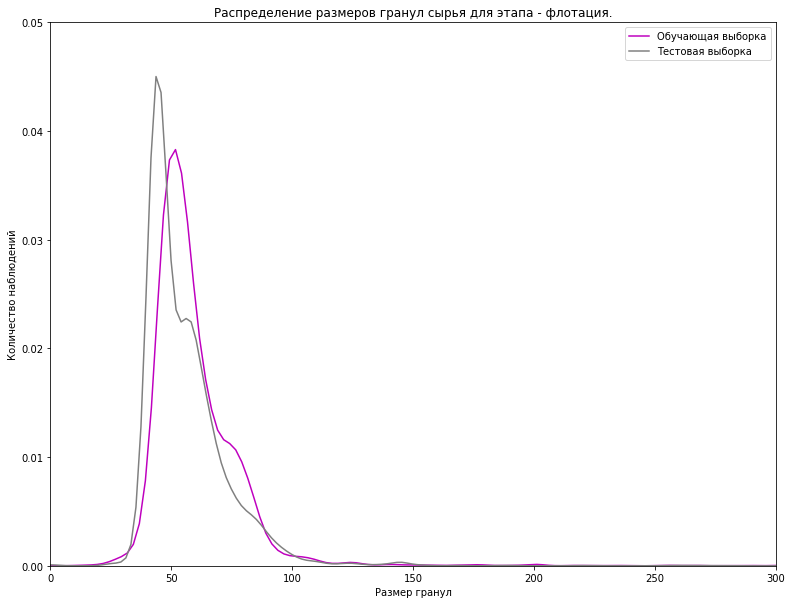

In [30]:
plt.figure(figsize=[13, 10])

sns.kdeplot(df_train['rougher.input.feed_size'], label='Обучающая выборка', color='m')
sns.kdeplot(df_test['rougher.input.feed_size'], label='Тестовая выборка', color='grey')



plt.xlim([0, 300])
plt.ylim([0, 0.05])

plt.xlabel('Размер гранул')
plt.ylabel('Плотность распределения')

plt.legend(loc='upper right')
plt.title('Распределение размеров гранул сырья для этапа - флотация.')
plt.show()

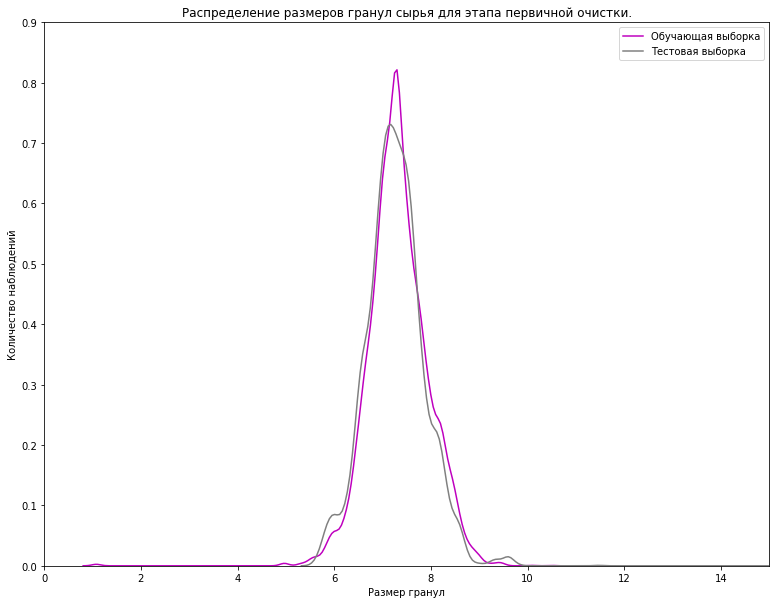

In [31]:
plt.figure(figsize=[13, 10])

sns.kdeplot(df_train['primary_cleaner.input.feed_size'], label='Обучающая выборка', color='m')
sns.kdeplot(df_test['primary_cleaner.input.feed_size'], label='Тестовая выборка', color='grey')

plt.xlim([0, 15])
plt.ylim([0, 0.9])

plt.xlabel('Размер гранул')
plt.ylabel('Плотность распределения')

plt.legend(loc='upper right')
plt.title('Распределение размеров гранул сырья для этапа первичной очистки.')
plt.show()

**Вывод:** \
Распределения практически не отличаются друг от друга и являются нормальными, следовательно оценка модели будет правильной.

**2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.** 

In [32]:
# сумма концентрации веществ на стадии сырья

rougher_input_concentrate_sum = (df_train['rougher.input.feed_ag'] 
                                 + df_train['rougher.input.feed_pb']
                                 + df_train['rougher.input.feed_sol'] 
                                 + df_train['rougher.input.feed_au'])

In [33]:
# сумма концентрации веществ на черновой стадии, этап флотация

rougher_output_concentrate_sum = (df_train['rougher.output.concentrate_ag'] 
                                 + df_train['rougher.output.concentrate_pb']
                                 + df_train['rougher.output.concentrate_sol']
                                 + df_train['rougher.output.concentrate_au'])

In [34]:
# сумма концентрации веществ на черновой стадии, этап первичная обработка

primary_cleaner_output_concentrate_sum = (df_train['primary_cleaner.output.concentrate_ag'] 
                                 + df_train['primary_cleaner.output.concentrate_pb']
                                 + df_train['primary_cleaner.output.concentrate_sol']
                                 + df_train['primary_cleaner.output.concentrate_au'])

In [35]:
# сумма концентрации веществ на финальной стадии 

final_output_concentrate_sum = (df_train['final.output.concentrate_ag'] 
                                 + df_train['final.output.concentrate_pb']
                                 + df_train['final.output.concentrate_sol']
                                 + df_train['final.output.concentrate_au'])

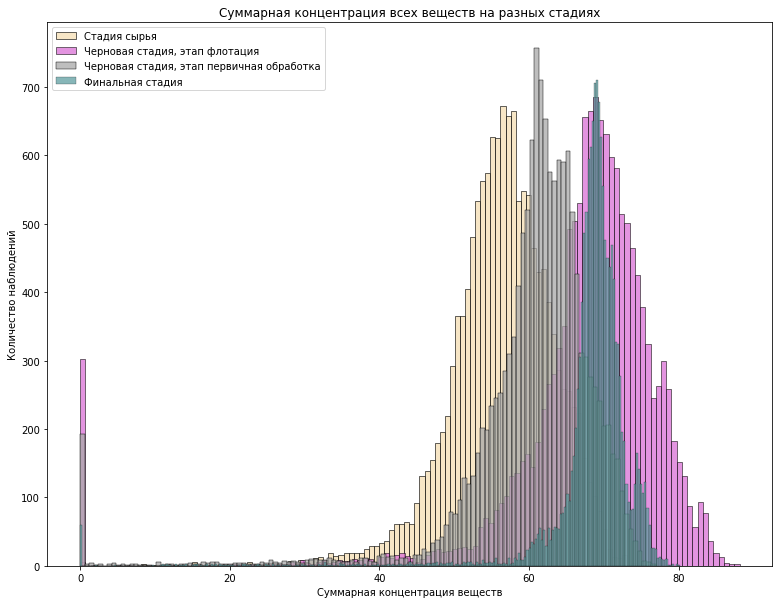

In [36]:
plt.figure(figsize=[13, 10])

sns.histplot(rougher_input_concentrate_sum, label='Стадия сырья', color='wheat')

sns.histplot(rougher_output_concentrate_sum, label='Черновая стадия, этап флотация', 
             color='orchid')

sns.histplot(primary_cleaner_output_concentrate_sum, 
             label='Черновая стадия, этап первичная обработка',
             color='darkgrey')

sns.histplot(final_output_concentrate_sum, label='Финальная стадия', color='cadetblue')


plt.xlabel('Cуммарная концентрация веществ')
plt.ylabel('Количество наблюдений')

plt.legend(loc='upper left')
plt.title('Cуммарная концентрация всех веществ на разных стадиях')
plt.show()

In [37]:
print('Средняя концентрация веществ на стадии сырья:', 
      rougher_input_concentrate_sum.mean().round(2))

print('Средняя концентрация веществ на черновой стадии, этап флотация:', 
      rougher_output_concentrate_sum.mean().round(2))

print('Средняя концентрация веществ на черновой стадии, этап первичная обработка:', 
      primary_cleaner_output_concentrate_sum.mean().round(2))

print('Средняя концентрация веществ на финальной стадии:', 
      final_output_concentrate_sum.mean().round(2))

Средняя концентрация веществ на стадии сырья: 56.24
Средняя концентрация веществ на черновой стадии, этап флотация: 67.17
Средняя концентрация веществ на черновой стадии, этап первичная обработка: 60.17
Средняя концентрация веществ на финальной стадии: 68.39


**Вывод:**

**Суммарная концентрация веществ увеличивается к финальному этапу:**
- средняя концентрация веществ на стадии сырья: 56.24;
- средняя концентрация веществ на черновой стадии, этап флотация: 67.17;
- средняя концентрация веществ на черновой стадии, этап первичная обработка: 60.17;
- средняя концентрация веществ на финальной стадии: 68.39.

**Видим много аномальных значений в районе нуля. Удалим их, чтобы они не повлияли на качество обучения:**

In [38]:
# Для обучающей выборки

df_train = df_train[(df_train['rougher.input.feed_ag'] >= 1) 
                    & (df_train['rougher.input.feed_pb'] >= 1)
                    & (df_train['rougher.input.feed_sol'] >= 1) 
                    & (df_train['rougher.input.feed_au'] >= 1)
                    & (df_train['rougher.output.concentrate_ag'] >= 1) 
                    & (df_train['rougher.output.concentrate_pb'] >= 1)
                    & (df_train['rougher.output.concentrate_sol'] >= 1)
                    & (df_train['rougher.output.concentrate_au'] >= 1)
                    & (df_train['primary_cleaner.output.concentrate_ag'] >= 1)
                    & (df_train['primary_cleaner.output.concentrate_pb'] >= 1)
                    & (df_train['primary_cleaner.output.concentrate_sol'] >= 1)
                    & (df_train['primary_cleaner.output.concentrate_au'] >= 1)
                    & (df_train['final.output.concentrate_ag'] >= 1) 
                    & (df_train['final.output.concentrate_pb'] >= 1)
                    & (df_train['final.output.concentrate_sol'] >= 1)
                    & (df_train['final.output.concentrate_au'] >= 1)]

In [39]:
# Для тестовой выборки

df_test = df_test[(df_test['rougher.input.feed_ag'] >= 1) 
                    & (df_test['rougher.input.feed_pb'] >= 1)
                    & (df_test['rougher.input.feed_sol'] >= 1) 
                    & (df_test['rougher.input.feed_au'] >= 1)]

In [40]:
# Для исходных данных

df_full = df_full[(df_full['rougher.input.feed_ag'] >= 1) 
                    & (df_full['rougher.input.feed_pb'] >= 1)
                    & (df_full['rougher.input.feed_sol'] >= 1) 
                    & (df_full['rougher.input.feed_au'] >= 1)
                    & (df_full['rougher.output.concentrate_ag'] >= 1) 
                    & (df_full['rougher.output.concentrate_pb'] >= 1)
                    & (df_full['rougher.output.concentrate_sol'] >= 1)
                    & (df_full['rougher.output.concentrate_au'] >= 1)
                    & (df_full['primary_cleaner.output.concentrate_ag'] >= 1)
                    & (df_full['primary_cleaner.output.concentrate_pb'] >= 1)
                    & (df_full['primary_cleaner.output.concentrate_sol'] >= 1)
                    & (df_full['primary_cleaner.output.concentrate_au'] >= 1)
                    & (df_full['final.output.concentrate_ag'] >= 1) 
                    & (df_full['final.output.concentrate_pb'] >= 1)
                    & (df_full['final.output.concentrate_sol'] >= 1)
                    & (df_full['final.output.concentrate_au'] >= 1)]

**Вывод:**
- аномальные значения удалены.

**Промежуточный вывод:** \
Проведён анализ данных: 

Концентрация золота увеличивается после каждого этапа очистки:
- cредняя концентрация золота на этапе сырья: 7.87;
- средняя концентрация золота после флотации: 19.91;
- cредняя концентрация золота после первичной очистки: 32.84;
- cредняя концентрация золота на финальном этапе: 44.23.

Концентрация серебра уменьшается после каждого этапа очистки:
- средняя концентрация серебра на этапе сырья: 8.58;
- средняя концентрация серебра после флотации: 12.01;
- средняя концентрация серебра после первичной очистки: 8.35;
- средняя концентрация серебра на финальном этапе: 5.16.

Концентрация свинца увеличивается, но не сильно после каждого этапа очистки:
- средняя концентрация свинца на этапе сырья: 3.51;
- средняя концентрация свинца после флотации: 7.87;
- средняя концентрация свинца после первичной очистки: 9.77;
- средняя концентрация свинца на финальном этапе: 10.22.
Распределения практически не отличаются друг от друга и являются нормальными, следовательно оценка модели будет правильной.;

Суммарная концентрация веществ увеличивается к финальному этапу:

- средняя концентрация веществ на стадии сырья: 56.24;
- средняя концентрация веществ на черновой стадии, этап флотация: 67.17;
- средняя концентрация веществ на черновой стадии, этап первичная обработка: 60.17;
- средняя концентрация веществ на финальной стадии: 68.39.

Аномальные значения удалены.


## Модель

**3.1 Напишем функцию для вычисления итоговой sMAPE.**

In [41]:
# Вычисление sMAPE

def smape(target, predict):
    return (100/len(target) * np.sum(2 * np.abs(target - predict) / (np.abs(target) + np.abs(predict)))
            *(-1))
            

In [42]:
# Вычисление итоговой sMAPE

def final_smape(smape_rougher, smape_final):
    return (0.25 * smape_rougher + 0.75 * smape_final)    

In [43]:
smape_scorer = make_scorer(smape, greater_is_better = False)

In [44]:
# Удалим из обучающей выборки признаки, которые отсутствуют в тестовой выборке

df_train = df_train.drop(columns = signs_missed - set(['rougher.output.recovery','final.output.recovery']), axis=1)

In [45]:
# Проверим

print('Количество признаков в обучающей выборке:', len(df_train.columns))
print('Количество признаков в тестовой выборке:', len(df_test.columns))

Количество признаков в обучающей выборке: 55
Количество признаков в тестовой выборке: 55


In [46]:
# Формируем фичи и целевую

features_train = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_train = df_train['rougher.output.recovery'] 
target_final_train = df_train['final.output.recovery'] 


**3.2 Обучим разные модели и оценим их качество кросс-валидацией.**

**LinearRegression()**

In [47]:
%%time
# РАСЧЁТ МОДЕЛИ LinearRegression() С ПОМОЩЬЮ КРОСС-ВАЛИДАЦИИ
model_lr_rougher = LinearRegression()
scores_rougher_lr = cross_val_score(model_lr_rougher, 
                                    features_train, 
                                    target_rougher_train, 
                                    cv=5, 
                                    scoring=smape_scorer)

model_lr_final = LinearRegression()
scores_final_lr = cross_val_score(model_lr_final, 
                                  features_train, 
                                  target_final_train, 
                                  cv=5, 
                                  scoring=smape_scorer)

# МЕТРИКА
print('Метрика sMAPE для LinearRegression_rougher:', np.mean(scores_rougher_lr))
print('Метрика sMAPE для LinearRegression_final:', np.mean(scores_final_lr))

Метрика sMAPE для LinearRegression_rougher: 7.281963445865566
Метрика sMAPE для LinearRegression_final: 10.676502645068076
CPU times: user 613 ms, sys: 1.44 s, total: 2.06 s
Wall time: 1.94 s


**RandomForestRegressor()**

In [48]:
# Сделаем заготовку к масштабированию

preprocessing = make_pipeline(StandardScaler())

# Обозначим модель

model_rfr = RandomForestRegressor(random_state = RANDOM_STATE)

# Сформируем шаги пайплайна
full_pipe_rfr = Pipeline([('preprocessor', preprocessing), ('model', model_rfr)])

# Зададим параметры
param_grid_rfr = {
    'model__n_estimators': range (1,300,20),
    'model__max_depth': range (1, 11),
    'model__min_samples_split': range (1,10),
    'model__min_samples_leaf': range (2,8)
}

In [49]:
%%time

# Подберем гиперпараметры
grid_rougher_rfr = RandomizedSearchCV(
    full_pipe_rfr, param_grid_rfr, scoring=smape_scorer, cv=5, 
    random_state=RANDOM_STATE)

grid_final_rfr = RandomizedSearchCV(
    full_pipe_rfr, param_grid_rfr, scoring=smape_scorer, cv=5, 
    random_state=RANDOM_STATE)

# Обучим модель  
model_rougher_rfr = grid_rougher_rfr.fit(features_train, target_rougher_train)
model_final_rfr = grid_final_rfr.fit(features_train, target_final_train)

CPU times: user 37min 3s, sys: 5.13 s, total: 37min 8s
Wall time: 37min 9s


In [50]:
print(f'Лучшие параметры для случайного леса: ', model_rougher_rfr.best_params_)
print(f'Метрика sMAPE для лучших параметров: %.4f' % model_rougher_rfr.best_score_)

print(f'Лучшие параметры для случайного леса: ', model_final_rfr.best_params_)
print(f'Метрика sMAPE для лучших параметров: %.4f' % model_final_rfr.best_score_)


Лучшие параметры для случайного леса:  {'model__n_estimators': 41, 'model__min_samples_split': 2, 'model__min_samples_leaf': 6, 'model__max_depth': 3}
Метрика sMAPE для лучших параметров: 6.8217
Лучшие параметры для случайного леса:  {'model__n_estimators': 261, 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 10}
Метрика sMAPE для лучших параметров: 9.0126


**DecisionTreeRegressor()**

In [51]:
# Обозначим модель

model_dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)

# Сформируем шаги пайплайна

full_pipe_dtr = Pipeline([('preprocessor', preprocessing), ('model', model_dtr)])

# Зададим параметры

param_grid_dtr = {
    'model__max_depth': range (1, 11)
}

In [52]:
%%time

# Подберем гиперпараметры

grid_rougher_dtr = RandomizedSearchCV(
    full_pipe_dtr, param_grid_dtr, scoring=smape_scorer, cv=5, 
    random_state=RANDOM_STATE)

grid_final_dtr = RandomizedSearchCV(
    full_pipe_dtr, param_grid_dtr, scoring=smape_scorer, cv=5, 
    random_state=RANDOM_STATE)

# Обучим модель  

model_rougher_dtr = grid_rougher_dtr.fit(features_train, target_rougher_train)
model_final_dtr = grid_final_dtr.fit(features_train, target_final_train)

CPU times: user 26.3 s, sys: 60 ms, total: 26.3 s
Wall time: 26.3 s


In [53]:
print(f'Лучшие параметры для случайного леса: ', model_rougher_dtr.best_params_)
print(f'Метрика sMAPE для лучших параметров: %.4f' % model_rougher_dtr.best_score_)

print(f'Лучшие параметры для случайного леса: ', model_final_dtr.best_params_)
print(f'Метрика sMAPE для лучших параметров: %.4f' % model_final_dtr.best_score_)


Лучшие параметры для случайного леса:  {'model__max_depth': 10}
Метрика sMAPE для лучших параметров: 8.4007
Лучшие параметры для случайного леса:  {'model__max_depth': 10}
Метрика sMAPE для лучших параметров: 12.4888


In [54]:
final_smape_lr = final_smape(np.mean(scores_rougher_lr), np.mean(scores_final_lr))
print('Итоговая sMAPE для LinearRegression:', final_smape_lr)

final_smape_rfr = final_smape(model_rougher_rfr.best_score_ , model_final_rfr.best_score_)
print('Итоговая sMAPE для RandomForestRegressor:', final_smape_rfr)

final_smape_dtc = final_smape(model_rougher_dtr.best_score_ , model_final_dtr.best_score_)
print('Итоговая sMAPE для DecisionTreeRegressor:', final_smape_dtc)

Итоговая sMAPE для LinearRegression: 9.827867845267448
Итоговая sMAPE для RandomForestRegressor: 8.464862146568697
Итоговая sMAPE для DecisionTreeRegressor: 11.466760209328724


**Вывод:**
- Итоговая sMAPE для LinearRegression: 9.827867845267448
- Итоговая sMAPE для RandomForestRegressor: **8.464862146568697**
- Итоговая sMAPE для DecisionTreeRegressor: 11.466760209328724

Лучший результат у модели _Случайный Лес_ с параметрами: 
- 'n_estimators': 41, 
- 'min_samples_split': 2,
- 'min_samples_leaf': 6, 
- 'max_depth': 3, \
её и будем проверять на тестовой выборке.


**3.3 Проверим модель на тестовой выборке.**

In [55]:
features_test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_test = df_test['rougher.output.recovery'] 
target_final_test = df_test['final.output.recovery'] 

In [56]:
test_rougher = model_rougher_rfr.predict(features_test)
test_final = model_final_rfr.predict(features_test)

In [57]:
smape_rougher_test = smape(target_rougher_test, test_rougher)
smape_final_test =  smape(target_final_test, test_final)
final_smape_test = final_smape(smape_rougher_test , smape_final_test)

print('Итоговая sMAPE на тестовой выборке:', -final_smape_test)

Итоговая sMAPE на тестовой выборке: 9.2096370092423


**3.4 Проверим модель на адекватность.**

In [58]:
dummy_rougher = DummyRegressor(strategy='median')
dummy_final = DummyRegressor(strategy='median')
    
dummy_rougher.fit(features_train, target_rougher_train)
dummy_final.fit(features_train, target_final_train)
    
rougher = dummy_rougher.predict(features_test)
final = dummy_final.predict(features_test)

smape_rougher_dummy = smape(target_rougher_test, rougher)
smape_final_dummy =  smape(target_final_test, final)
final_smape_dummy = final_smape(smape_rougher_dummy, smape_final_dummy)

print('Итоговая sMAPE константной модели:', -final_smape_dummy)

Итоговая sMAPE константной модели: 9.300311048816754


**Вывод:**
- Итоговая sMAPE на тестовой выборке: 9.2096370092423
- Итоговая sMAPE константной модели: 9.300311048816754

У констатной модели значение метрики sMAPE ниже, поэтому можем считать нашу модель адекватной.

**Общий вывод:**
1. **_Были подготовлены данные:_**
- мы имеем три таблицы: обучающая выборка, тестовая выборка и исходные данные;
- во всех таблицах есть пропуски;
- некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже.

2. **_Проверено, что эффективность обогащения рассчитана правильно:_** 
- абсолютная средняя ошибка между расчётами и значением признака = 9.73512347450521e-15 и очень мала, из чего следует, что наши расчёты верны.

3. **_Проанализированы признаки, недоступные в тестовой выборке:_**
- все столбцы имеют тип - float64;
- в тестовой выборке недоступны 34 признака;
- 30 признаков имеют тип - _параметры продукта_;
- 4 признака имеют тип - _расчётные характеристики_.


**Отсутствуют 12 признаков на стадии _флотации_:**
- 'rougher.output.concentrate_ag',
- 'rougher.output.concentrate_au',
- 'rougher.output.concentrate_pb',
- 'rougher.output.concentrate_sol',
- 'rougher.output.tail_ag',
- 'rougher.output.tail_au',
- 'rougher.output.tail_pb',
- 'rougher.output.tail_sol',
- 'rougher.calculation.au_pb_ratio',
- 'rougher.calculation.floatbank10_sulfate_to_au_feed',
- 'rougher.calculation.floatbank11_sulfate_to_au_feed',
- 'rougher.calculation.sulfate_to_au_concentrate',


**Отсутствуют 8 признаков на стадии _первичной_очистки_:**
- 'primary_cleaner.output.concentrate_ag',
- 'primary_cleaner.output.concentrate_au',
- 'primary_cleaner.output.concentrate_pb',
- 'primary_cleaner.output.concentrate_sol',
- 'primary_cleaner.output.tail_ag',
- 'primary_cleaner.output.tail_au',
- 'primary_cleaner.output.tail_pb',
- 'primary_cleaner.output.tail_sol',

**Отсутствуют 4 признака на стадии _вторичной_очистки_:**
- 'secondary_cleaner.output.tail_ag',
- 'secondary_cleaner.output.tail_au',
- 'secondary_cleaner.output.tail_pb',
- 'secondary_cleaner.output.tail_sol'}

**Отсутствуют 8 признаков на стадии _финальные характеристики_:**
- 'final.output.concentrate_ag',
- 'final.output.concentrate_au',
- 'final.output.concentrate_pb',
- 'final.output.concentrate_sol',
- 'final.output.tail_ag',
- 'final.output.tail_au',
- 'final.output.tail_pb',
- 'final.output.tail_sol',

**Отсутствуют 2 целевых признака:**
- 'rougher.output.recovery',
- 'final.output.recovery'.


4. **_Произведена предобработка данных:_**
- заполнены пропущенные значения;
- удалены аномальные значения;
- в тестовый набор добавлены целевые признаки.

5. **_Проведён анализ данных:_**

**Концентрация золота увеличивается после каждого этапа очистки:**
- cредняя концентрация золота на этапе сырья: 7.87;
- средняя концентрация золота после флотации: 19.91;
- cредняя концентрация золота после первичной очистки: 32.84;
- cредняя концентрация золота на финальном этапе: 44.23.

**Концентрация серебра уменьшается после каждого этапа очистки:**
- средняя концентрация серебра на этапе сырья: 8.58;
- средняя концентрация серебра после флотации: 12.01;
- средняя концентрация серебра после первичной очистки: 8.35;
- средняя концентрация серебра на финальном этапе: 5.16.

**Концентрация свинца увеличивается, но не сильно после каждого этапа очистки:**
- средняя концентрация свинца на этапе сырья: 3.51;
- средняя концентрация свинца после флотации: 7.87;
- средняя концентрация свинца после первичной очистки: 9.77;
- средняя концентрация свинца на финальном этапе: 10.22.

Распределения практически не отличаются друг от друга и являются нормальными, следовательно оценка модели будет правильной.;

**Суммарная концентрация веществ увеличивается к финальному этапу:**
- средняя концентрация веществ на стадии сырья: 56.24;
- средняя концентрация веществ на черновой стадии, этап флотация: 67.17;
- средняя концентрация веществ на черновой стадии, этап первичная обработка: 60.17;
- средняя концентрация веществ на финальной стадии: 68.39.

6. **_Построена модель:_**
**Написали функцию для вычисления итоговой sMAPE. Обучили три модели и оценили их качество кросс-валидацией:**
- Итоговая sMAPE для LinearRegression: 9.827867845267448
- Итоговая sMAPE для RandomForestRegressor: **8.464862146568697**
- Итоговая sMAPE для DecisionTreeRegressor: 11.466760209328724

**Выбрали лучшую модель и проверили её на тестовой выборке:** \
Лучший результат у модели _Случайный Лес_ с параметрами: 
- 'n_estimators': 41, 
- 'min_samples_split': 2,
- 'min_samples_leaf': 6, 
- 'max_depth': 3. 

- Итоговая sMAPE на тестовой выборке: 9.2096370092423
- Итоговая sMAPE константной модели: 9.300311048816754

У констатной модели значение метрики sMAPE ниже, поэтому можем считать нашу модель адекватной.

